In [256]:
# En esta celda se puede probar la funcion de analisis de una imagen

from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Path completo donde esta la imagen (incluyendo nombre y extencion)
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/031019Sel/031019c3/'
photo_name = 'c3f000'
photo = photo_name + '.tif'
# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 33
# Calibracion del tiempo de cada pixel
calibration = 4.5

image = cv2.imread(path + photo_name + '.tif')
# Select ROI
fromCenter = False
showCrosshair = False
seleted_parameters = cv2.selectROI(image, fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0])
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()

image = image_data.get_image_data(image)
image = image_data.crop_vertical(image, x_start, x_end)
image = image_data.crop_horizontal(image, y_start, y_end)

results = dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=slice_width)

In [257]:
jasonGenerator(path,results,photo_name)

In [258]:
print(results['image']['max_peaks_positions'])
for i in range(0,len(results['slices'])):
    array = results['slices'][i]['max_peaks_positions']
    print(i,array)

[22, 69, 117]
0 [20, 77, 114]
1 [27, 69, 114]
2 [28, 67, 115]
3 [28, 69, 115]
4 [27, 73, 115]
5 [23, 70, 117]
6 [21, 68, 116]
7 [22, 68, 117]
8 [22, 67, 119]
9 [24, 63, 120]
10 [24, 70, 120]
11 [22, 67, 119]
12 [19, 68, 118]
13 [21, 68, 122]
14 [21, 69, 128]
15 [22, 69, 122]
16 [21, 70, 119]
17 [22, 75, 120]
18 [21, 73, 113]
19 [21, 73, 114]
20 [20, 70, 114]
21 [18, 70, 115]
22 [19, 70, 118]
23 [21, 69, 122]
24 [27, 71, 123]
25 [22, 69, 122]
26 [23, 69, 119]
27 [29, 68, 118]
28 [21, 67, 119]
29 [23, 69, 115]
30 [19, 68, 115]


In [ ]:
import matplotlib.pyplot as plt

for i in range(0,len(results['slices'])):
    array = results['slices'][i]['intensities']
    plt.plot(array) # plotting by columns
    plt.show()

# PRUEBA ANALISIS 

In [ ]:
# En esta celda se puede probar la funcion de analisis todas las imagenes .tif en un directorio
import os
from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 200

# Calibracion del tiempo de cada pixel
calibration = 3.1

# Path donde estan las imagenes
path = "C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/1 Hz/"

images_paths = [ f'{path}/{file}' for file in os.listdir(path) if file.endswith(".tif") ]
images = [ cv2.imread(image_path) for image_path in images_paths ]

In [ ]:
fromCenter = False
showCrosshair = False

#Tomamos la primer imagen para seleccionar el recorte elegido el resto de las imagenes se van a recortar igual
seleted_parameters = cv2.selectROI(images[0], fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0])
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()

In [ ]:
images = [ image_data.get_image_data(image) for image in images ]
images = [ image_data.crop_vertical(image, x_start, x_end) for image in images ]
images = [ image_data.crop_horizontal(image, y_start, y_end) for image in images ]

In [ ]:
results = [(dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=5), print ('Done')) for image in images]

# Analisis de datos
Notas: 
- Image corresponde al análisis de toda la célula y slices corresponde a fetas de esa imagen
- intensidades es el valor que resulta de comprimir (sumando) la matriz con las coordenadas de x,y,z de los pixeles 
- max_peaks_pos es la index de en la lista de intensidades 
- max_peaks_intensities el valor de intensidad que se corresponde con el pico en la posicion analoga de max_peaks_pos

In [1]:
#Imports
import json
import numpy as np
import pandas as pd

In [2]:
#encodes a dictionary into a jason
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def jasonGenerator(path,results,photo_name):
    """ Generates a .jason file in the path given folder from the a dictionary """
    with open(path + '/analysis_result_' + photo_name + '.json',"w") as miarch:
        miarch.write(json.dumps(results, cls=NumpyEncoder))

In [3]:
def jasonReader(path):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open(path,'r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [4]:
def slicesParser_max_peaksI(dictres):
#extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x) for x in range(0,len(allSlices[0]['max_peaks_intensities']))]    
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    for i in range(0,len(allSlices)):
        df_sum.loc[i] = allSlices[i]['max_peaks_intensities'][0:] 
    return df_sum

In [5]:
def slicesParser_halfpeakstime(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_half_peaks']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['times_to_half_peaks']
    return df_sum

In [6]:
def slicesParser_amplitudes(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['amplitudes']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['amplitudes']

    return df_sum

In [7]:
def slicesParser_min_peaksI(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['min_peaks_intensities']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['min_peaks_intensities']

    return df_sum

In [8]:
def slicesParser_peaktime(dictres):
    #extract all the slices data
    allSlices = dictres['slices']

    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_peaks']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['times_to_peaks']

    return df_sum

In [9]:
def slicesParser_tau(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['tau_s']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['tau_s']

    return df_sum

In [10]:
def BasicStasts(df):
    if df.empty == False:
        return df.astype('int').describe()

In [11]:
def amplitudes_ratio(df):
    df_alt = pd.DataFrame()
    for i in range(0,len(list(df))-1):
        name = 'ratio' + str(i+1) +'-' + str(i)
        df_alt[name] = df[list(df)[i+1]]/df[list(df)[i]]
    return df_alt

In [74]:
# path = '/home/leandro/Documentos/Analisis_de_imagenes/CardiAP/DesktopApp/photos_examples/'
photo_name = 'c1d000'
photo = photo_name + '.tif'

In [ ]:
loaded_dict = jasonReader(path)

In [ ]:
BasicStasts(slicesParser_max_peaksI(path))

In [ ]:
amplitudes_ratio(slicesParser_amplitudes(path)).std()

In [ ]:
amp_mean = slicesParser_amplitudes(path).mean()
for i in range(0,len(amp_mean)-1):
    AR_ind = (1- (amp_mean[i+1])/amp_mean[i])
    print (AR_ind)

In [72]:
slicesParser_min_peaksI(path).head(2)

no possible callculation


In [ ]:
slicesParser_tau(path).head()

In [39]:
def discordance_index(path):
    DIs = pd.DataFrame()
    for j in range (1, len(slicesParser_amplitudes(path).columns)):
        rel_diff = []
        for i in range (0, len (slicesParser_amplitudes(path))):
            T1 = list(slicesParser_amplitudes(path)['transient'+str(j)])[i]
            T2 = list(slicesParser_amplitudes(path)['transient'+str(j+1)])[i]
            rel_diff.append((T1-T2)/max(T1,T2))
        DIs[j] = rel_diff
    return DIs
def alternance_ratio(path):
    T1_mean = float(slicesParser_amplitudes(path)['transient1'].mean())
    T2_mean = float(slicesParser_amplitudes(path)['transient2'].mean())
    AR = (T1_mean-T2_mean)/T1_mean
    return AR

In [264]:
DI_list = []
import os
import shutil
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/jsons/'
jsons_list = os.listdir(path)
for file in jsons_list:
    path_file = path + file
    dic = jasonReader(path_file)
    print (file)
    DI_list.append(discordance_index(dic))
print('Done')

010719ctrol1_analysis_result_ctrol1a0.json
010719ctrol1_analysis_result_ctrol1b0.json
010719ctrol8_analysis_result_ctrol8a0.json
010719ctrol8_analysis_result_ctrol8b0.json
010719Dan2_analysis_result_dan2a000.json
010719Dan2_analysis_result_dan2b000.json
010719Dan6_analysis_result_dan6b000.json
010719VK3_analysis_result_vk3a000.json
010719VK3_analysis_result_vk3b002.json
010719VK7_analysis_result_vk7b000.json
010819c1_analysis_result_c1a000.json
010819c1_analysis_result_c1b000.json
010819c2_analysis_result_c2a000.json
010819c2_analysis_result_c2b000.json
010819c3_analysis_result_c3a000.json
010819c3_analysis_result_c3b001.json
010819c3_analysis_result_c3c000.json
031019c1_analysis_result_c1b000.json
031019c1_analysis_result_c1e000.json
031019c2_analysis_result_c2b000.json
031019c2_analysis_result_c2e000.json
031019c2_analysis_result_c2f000.json
031019c3_analysis_result_c3b000.json
031019c3_analysis_result_c3e000.json
031019c3_analysis_result_c3f000.json
031019c4_analysis_result_c4b000.j

In [276]:
file = []
for index in range(0,len(DI_list)):
    file.append([jsons_list[index], DI_list[index].std().mean()])

In [288]:
import csv
import pandas as pd    

df = pd.DataFrame(file, columns= ['photo_name','DI'])
df.to_csv(path + 'discordances_indexes.csv', sep='\t')

In [259]:
arch_defectuosos = []
for i in list_archs:
    dic = jasonReader(i)
    try:
        slicesParser_max_peaksI(dic)
    except:
        arch_defectuosos.append(i)

In [260]:
arch_defectuosos

[]

In [40]:
import os

AR_list = []
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/jsons/'
jsons_list = os.listdir(path)
for file in jsons_list:
    path_file = path + file
    dic = jasonReader(path_file)
    T1_mean = float(slicesParser_amplitudes(dic)['transient1'].mean())
    T2_mean = float(slicesParser_amplitudes(dic)['transient2'].mean())
    AR_list.append([file, alternance_ratio(dic)])
print('Done')

Done


In [41]:
import csv
import pandas as pd    

df = pd.DataFrame(AR_list, columns= ['photo_name','AR'])
df.to_csv(path + 'alternance_ratio.csv', sep='\t')

In [70]:
disc_index = pd.read_csv('C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/discordances_indexes.csv', encoding='utf-8', sep='\t')

In [109]:
DI_1hz_C = (disc_index[(disc_index['Frecuencia'] == 1) & (disc_index['Tratamiento'] =='C')]['DI'])
DI_5hz_C = disc_index[(disc_index['Frecuencia'] == 5) & (disc_index['Tratamiento'] =='C')]['DI']
DI_1hz_D = disc_index[(disc_index['Frecuencia'] == 1) & (disc_index['Tratamiento'] =='D')]['DI']
DI_5hz_D = disc_index[(disc_index['Frecuencia'] == 5) & (disc_index['Tratamiento'] =='D')]['DI']
DI_1hz_V = disc_index[(disc_index['Frecuencia'] == 1) & (disc_index['Tratamiento'] =='V')]['DI']
DI_5hz_V = disc_index[(disc_index['Frecuencia'] == 5) & (disc_index['Tratamiento'] =='V')]['DI']

df = pd.concat([DI_1hz_C,DI_5hz_C,DI_1hz_D,DI_5hz_D,DI_1hz_V,DI_5hz_V], ignore_index=True, axis=1)

In [112]:
df.describe()

,0,1,2,3,4,5
count,34.000000,33.000000,14.000000,13.000000,13.000000,12.000000
mean,0.117978,0.353373,0.092301,0.289396,0.130690,0.351256
std,0.059664,0.173271,0.033214,0.161938,0.078172,0.152062
min,0.038791,0.081298,0.043187,0.039714,0.040843,0.074593
25%,0.080783,0.219295,0.067127,0.185856,0.079367,0.223329
50%,0.111002,0.342517,0.092929,0.241153,0.091932,0.381029
75%,0.130736,0.484874,0.120947,0.380598,0.149950,0.464703
max,0.333030,0.698376,0.150613,0.621010,0.300093,0.587822


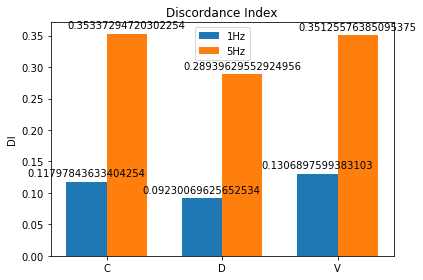

In [124]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['C', 'D', 'V']
Hz1 = [DI_1hz_C.mean(), DI_1hz_D.mean(), DI_1hz_V.mean()]
Hz5 = [DI_5hz_C.mean(), DI_5hz_D.mean(), DI_5hz_V.mean()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Hz1, width, label='1Hz')
rects2 = ax.bar(x + width/2, Hz5, width, label='5Hz')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('DI')
ax.set_title('Discordance Index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/DI.png')

In [83]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
t, p = ttest_ind(DI_5hz_C['DI'], DI_5hz_D['DI'], equal_var=False)
p

0.24883812130736593

In [ ]:
import matplotlib.pyplot as plt

labels = ['C', 'D', 'V']
Hz1 = [DI_1hz_C.mean(), DI_1hz_D.mean(), DI_1hz_V.mean()]
Hz5 = [DI_5hz_C.mean(), DI_5hz_D.mean(), DI_5hz_V.mean()]


hist, edges = np.histogram(data, bins=bins)

y = np.arange(1,hist.max()+1)
x = np.arange(12)
X,Y = np.meshgrid(x,y)

plt.scatter(X,Y, c=Y<=hist, cmap="Greys")

plt.show()